In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
def generate_fraud_data(n_samples=10000):
    """Generate synthetic transaction data for fraud detection"""

    # Base transaction characteristics
    data = {
        'amount': np.random.exponential(100, n_samples),
        'time_of_day': np.random.randint(0, 24, n_samples),
        'day_of_week': np.random.randint(0, 7, n_samples),
        'merchant_category': np.random.randint(0, 10, n_samples),
        'customer_age': np.random.randint(18, 80, n_samples),
        'customer_income': np.random.normal(50000, 20000, n_samples),
        'transaction_frequency': np.random.poisson(5, n_samples),
        'location_mismatch': np.random.binomial(1, 0.1, n_samples),
        'device_type': np.random.randint(0, 4, n_samples)
    }

    df = pd.DataFrame(data)

    # Create fraud indicators (these would be patterns in real data)
    fraud_probability = (
        0.1 * (df['amount'] > 500) +  # Large transactions
        0.2 * (df['time_of_day'].isin([0, 1, 2, 3])) +  # Late night
        0.15 * (df['location_mismatch'] == 1) +  # Location mismatch
        0.1 * (df['merchant_category'].isin([8, 9])) +  # High-risk merchants
        0.05 * np.random.random(n_samples)  # Random noise
    )

    # Convert to binary fraud labels (only 2% fraud rate - realistic imbalance)
    df['is_fraud'] = (fraud_probability > fraud_probability.quantile(0.98)).astype(int)

    # Add some realistic noise to fraud patterns
    fraud_mask = df['is_fraud'] == 1
    df.loc[fraud_mask, 'amount'] *= np.random.uniform(1.5, 5.0, fraud_mask.sum())

    return df

# Generate the dataset
df = generate_fraud_data(10000)
print("Dataset shape:", df.shape)
print("\nFraud distribution:")
print(df['is_fraud'].value_counts())
print(f"Fraud rate: {df['is_fraud'].mean():.2%}")

Dataset shape: (10000, 10)

Fraud distribution:
is_fraud
0    9800
1     200
Name: count, dtype: int64
Fraud rate: 2.00%


Dataset Overview:
             amount   time_of_day   day_of_week  merchant_category  \
count  10000.000000  10000.000000  10000.000000       10000.000000   
mean     102.020215     11.593300      3.027300           4.590700   
std      114.063868      6.922708      1.990214           2.849278   
min        0.001163      0.000000      0.000000           0.000000   
25%       28.563451      6.000000      1.000000           2.000000   
50%       68.996223     12.000000      3.000000           5.000000   
75%      138.251580     18.000000      5.000000           7.000000   
max     2346.261179     23.000000      6.000000           9.000000   

       customer_age  customer_income  transaction_frequency  \
count  10000.000000     10000.000000           10000.000000   
mean      48.717900     49526.612516               5.002100   
std       18.024184     20093.666139               2.237185   
min       18.000000    -39312.077271               0.000000   
25%       33.000000     35783.026529

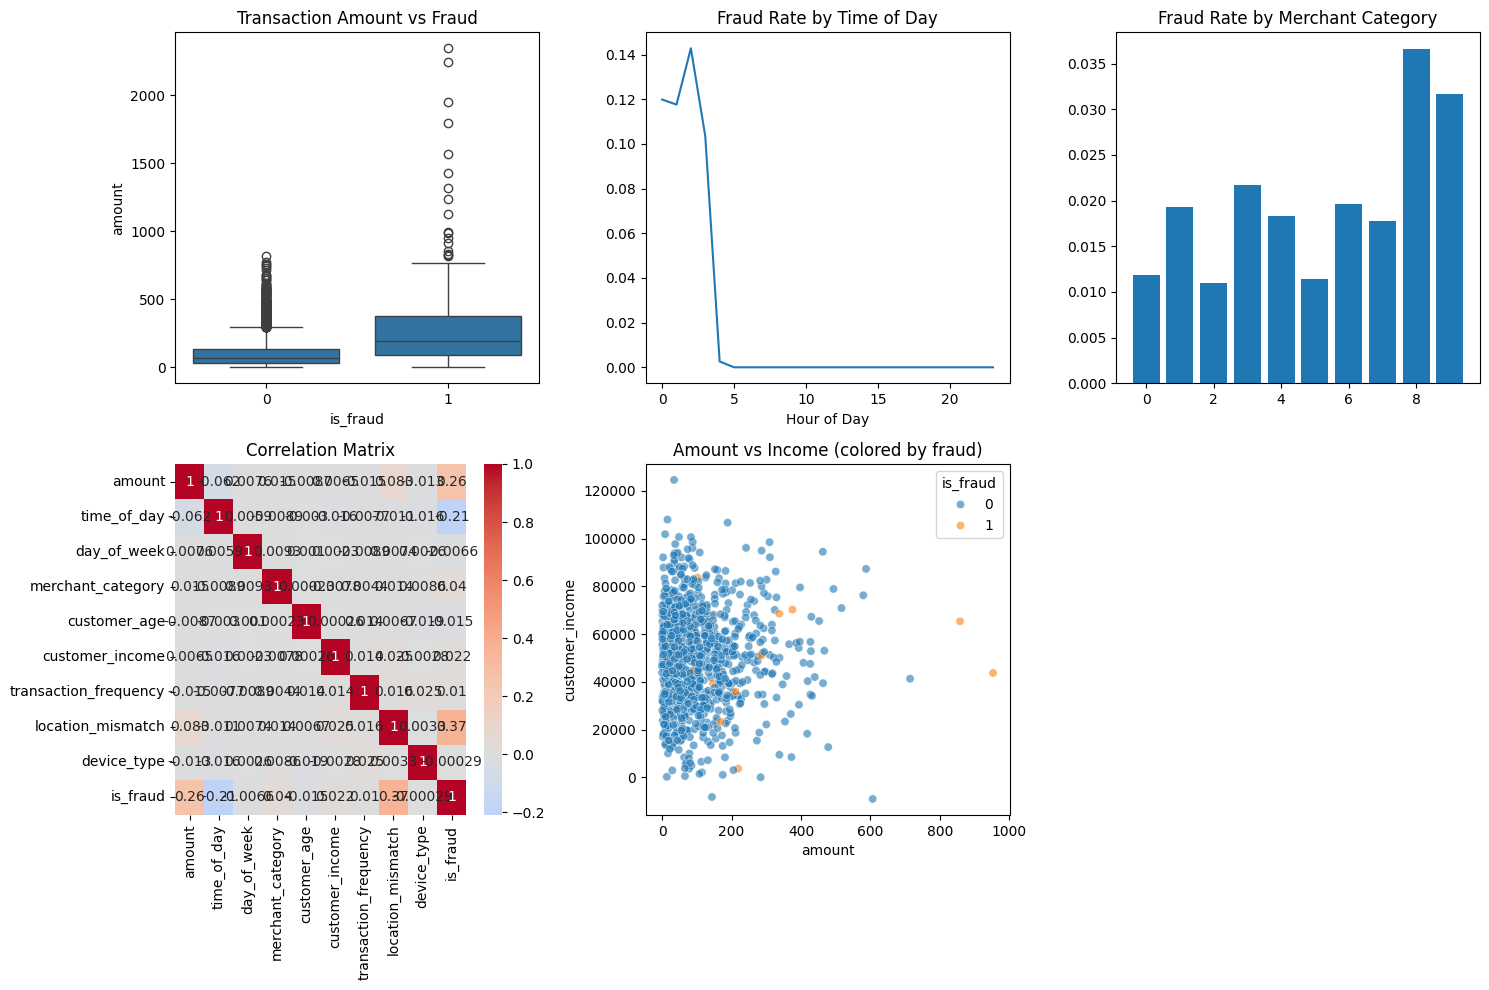

In [3]:
# Basic statistics
print("Dataset Overview:")
print(df.describe())

# Fraud distribution by various features
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.boxplot(x='is_fraud', y='amount', data=df)
plt.title('Transaction Amount vs Fraud')

plt.subplot(2, 3, 2)
fraud_by_time = df.groupby('time_of_day')['is_fraud'].mean()
plt.plot(fraud_by_time.index, fraud_by_time.values)
plt.title('Fraud Rate by Time of Day')
plt.xlabel('Hour of Day')

plt.subplot(2, 3, 3)
fraud_by_merchant = df.groupby('merchant_category')['is_fraud'].mean()
plt.bar(fraud_by_merchant.index, fraud_by_merchant.values)
plt.title('Fraud Rate by Merchant Category')

plt.subplot(2, 3, 4)
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')

plt.subplot(2, 3, 5)
sns.scatterplot(x='amount', y='customer_income', hue='is_fraud', data=df.sample(1000), alpha=0.6)
plt.title('Amount vs Income (colored by fraud)')

plt.tight_layout()
plt.show()

In [4]:
# Create additional features
df['amount_to_income_ratio'] = df['amount'] / (df['customer_income'] + 1)
df['hourly_pattern'] = (df['time_of_day'] >= 22) | (df['time_of_day'] <= 4)
df['weekend_transaction'] = df['day_of_week'] >= 5
df['high_amount_flag'] = df['amount'] > df['amount'].quantile(0.95)
df['unusual_frequency'] = df['transaction_frequency'] > df['transaction_frequency'].quantile(0.9)

# Select features for modeling
features = [
    'amount', 'time_of_day', 'day_of_week', 'merchant_category',
    'customer_age', 'customer_income', 'transaction_frequency',
    'location_mismatch', 'device_type', 'amount_to_income_ratio',
    'hourly_pattern', 'weekend_transaction', 'high_amount_flag',
    'unusual_frequency'
]

X = df[features]
y = df['is_fraud']

print("Feature set shape:", X.shape)

Feature set shape: (10000, 14)


In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Fraud rate in training: {y_train.mean():.2%}")
print(f"Fraud rate in test: {y_test.mean():.2%}")

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE:")
print(f"Training set: {X_train_resampled.shape[0]} samples")
print(f"Fraud rate in training: {y_train_resampled.mean():.2%}")

Training set: 7000 samples
Test set: 3000 samples
Fraud rate in training: 2.00%
Fraud rate in test: 2.00%

After SMOTE:
Training set: 13720 samples
Fraud rate in training: 50.00%


In [7]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Train multiple models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced')
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train_resampled)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train_resampled, y_train_resampled)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"{name} AUC Score: {auc_score:.4f}")


Training Random Forest...
Random Forest AUC Score: 0.9962

Training Logistic Regression...
Logistic Regression AUC Score: 0.9925



EVALUATION RESULTS FOR RANDOM FOREST
AUC Score: 0.9962

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      0.99      1.00      2940
       Fraud       0.70      0.93      0.80        60

    accuracy                           0.99      3000
   macro avg       0.85      0.96      0.90      3000
weighted avg       0.99      0.99      0.99      3000



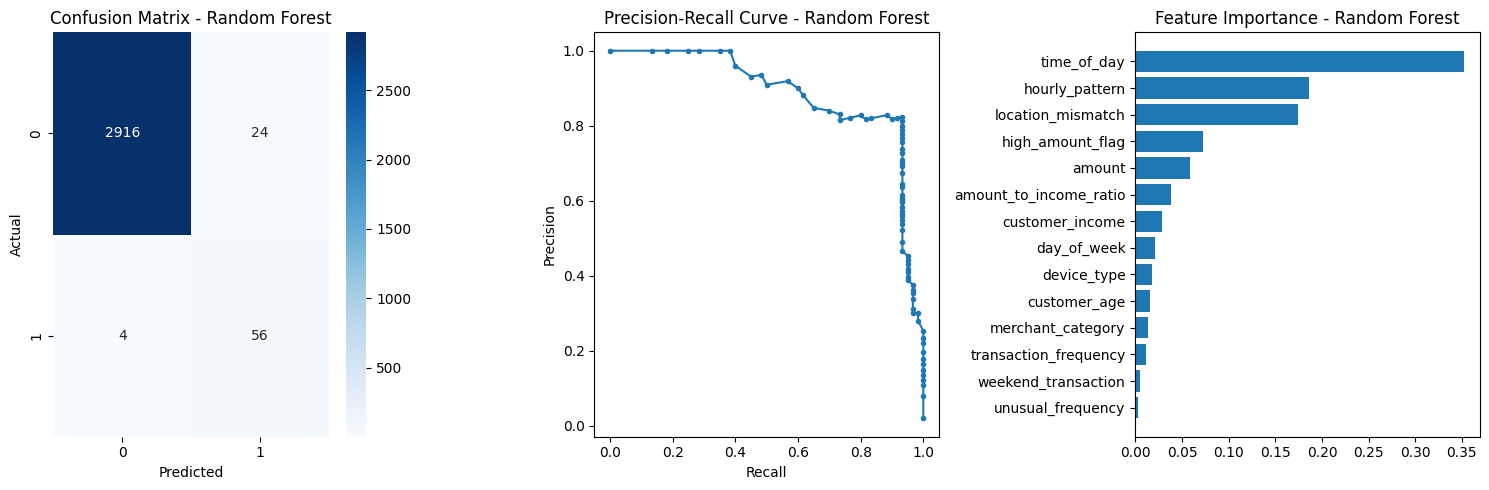


EVALUATION RESULTS FOR LOGISTIC REGRESSION
AUC Score: 0.9925

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      0.96      0.98      2940
       Fraud       0.35      0.95      0.51        60

    accuracy                           0.96      3000
   macro avg       0.67      0.96      0.75      3000
weighted avg       0.99      0.96      0.97      3000



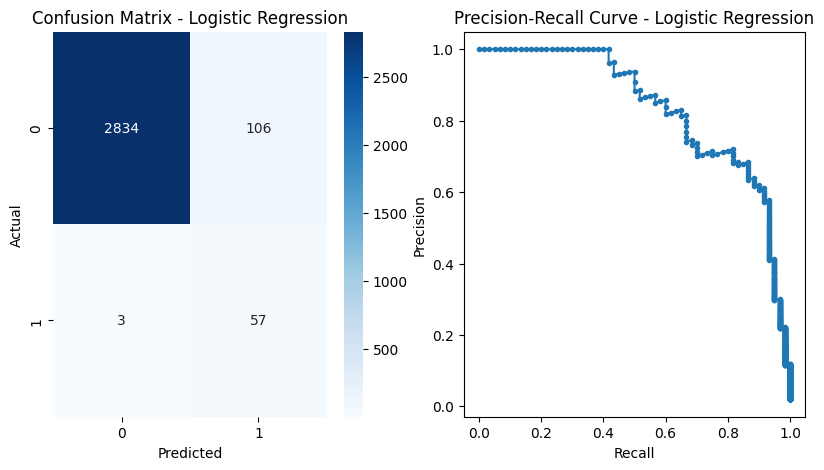

In [8]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """Comprehensive model evaluation"""

    print(f"\n{'='*50}")
    print(f"EVALUATION RESULTS FOR {model_name.upper()}")
    print(f"{'='*50}")

    # AUC Score
    auc = roc_auc_score(y_true, y_pred_proba)
    print(f"AUC Score: {auc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Legitimate', 'Fraud']))

    # Confusion Matrix
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Precision-Recall Curve
    plt.subplot(1, 3, 2)
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    plt.plot(recall, precision, marker='.')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    # Feature Importance (for Random Forest)
    if model_name == 'Random Forest':
        plt.subplot(1, 3, 3)
        feature_importance = results[model_name]['model'].feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': features,
            'importance': feature_importance
        }).sort_values('importance', ascending=True)

        plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
        plt.title('Feature Importance - Random Forest')
        plt.tight_layout()

    plt.show()

    return auc

# Evaluate each model
model_performance = {}
for name in models.keys():
    auc = evaluate_model(
        y_test,
        results[name]['y_pred'],
        results[name]['y_pred_proba'],
        name
    )
    model_performance[name] = auc

In [10]:
def find_optimal_threshold(y_true, y_pred_proba):
    """Find the optimal threshold for fraud detection"""

    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

    # Find threshold that maximizes F2-score (emphasizing recall)
    f2_scores = []
    for i in range(len(precision)-1):
        f2 = (5 * precision[i] * recall[i]) / (4 * precision[i] + recall[i] + 1e-8)
        f2_scores.append(f2)

    optimal_idx = np.argmax(f2_scores)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold, f2_scores[optimal_idx]

# Apply optimal threshold for Random Forest
optimal_threshold, best_f2 = find_optimal_threshold(y_test, results['Random Forest']['y_pred_proba'])
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Best F2-score: {best_f2:.4f}")

# Apply optimal threshold
y_pred_optimal = (results['Random Forest']['y_pred_proba'] >= optimal_threshold).astype(int)

print("\nPerformance with optimal threshold:")
print(classification_report(y_test, y_pred_optimal, target_names=['Legitimate', 'Fraud']))

Optimal threshold: 0.7400
Best F2-score: 0.9091

Performance with optimal threshold:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00      2940
       Fraud       0.82      0.93      0.88        60

    accuracy                           0.99      3000
   macro avg       0.91      0.96      0.94      3000
weighted avg       1.00      0.99      0.99      3000



In [11]:
class FraudDetector:
    def __init__(self, model, scaler=None, threshold=0.5):
        self.model = model
        self.scaler = scaler
        self.threshold = threshold
        self.features = features

    def predict_fraud(self, transaction_data):
        """Predict if a transaction is fraudulent"""

        # Ensure correct feature order
        X = pd.DataFrame([transaction_data])[self.features]

        # Scale if scaler is provided
        if self.scaler is not None:
            X = self.scaler.transform(X)

        # Predict probability
        fraud_probability = self.model.predict_proba(X)[0, 1]
        is_fraud = fraud_probability >= self.threshold

        return {
            'is_fraud': bool(is_fraud),
            'fraud_probability': float(fraud_probability),
            'risk_level': 'HIGH' if fraud_probability > 0.7 else
                         'MEDIUM' if fraud_probability > 0.3 else 'LOW'
        }

# Create fraud detector
fraud_detector = FraudDetector(
    model=results['Random Forest']['model'],
    threshold=optimal_threshold
)

# Test with sample transaction
sample_transaction = {
    'amount': 1500,
    'time_of_day': 2,
    'day_of_week': 6,
    'merchant_category': 9,
    'customer_age': 35,
    'customer_income': 60000,
    'transaction_frequency': 8,
    'location_mismatch': 1,
    'device_type': 3,
    'amount_to_income_ratio': 1500/60000,
    'hourly_pattern': True,
    'weekend_transaction': True,
    'high_amount_flag': True,
    'unusual_frequency': True
}

result = fraud_detector.predict_fraud(sample_transaction)
print("\nSample Transaction Analysis:")
for key, value in result.items():
    print(f"{key}: {value}")


Sample Transaction Analysis:
is_fraud: True
fraud_probability: 0.92
risk_level: HIGH


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

In [25]:
def generate_enhanced_fraud_data(n_customers=1000, transactions_per_customer=15):  # Further reduced for stability
    """Generate synthetic transaction data with sequential patterns and network effects"""

    # Customer profiles
    customers = []
    for i in range(n_customers):
        customers.append({
            'customer_id': i,
            'age': np.random.randint(18, 80),
            'income': max(20000, np.random.normal(60000, 25000)),
            'risk_profile': np.random.beta(2, 5),
            'base_location': np.random.randint(0, 50),
            'usual_device': np.random.randint(0, 3)
        })

    customer_df = pd.DataFrame(customers)

    # Generate transaction sequences
    transactions = []
    for _, customer in customer_df.iterrows():
        base_amount = np.random.exponential(50)

        for t in range(transactions_per_customer):
            # Fixed probability weights
            day = t % 30
            hours = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
            probabilities = [0.05, 0.07, 0.08, 0.09, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04]
            probabilities = [p/sum(probabilities) for p in probabilities]  # Normalize
            hour = np.random.choice(hours, p=probabilities)

            amount = base_amount * np.random.lognormal(0, 0.3)
            merchant = np.random.randint(0, 20)
            merchant_risk = merchant / 20.0

            transaction = {
                'transaction_id': len(transactions),
                'customer_id': customer['customer_id'],
                'amount': amount,
                'day_of_month': day,
                'hour_of_day': hour,
                'merchant_id': merchant,
                'merchant_risk': merchant_risk,
                'location': customer['base_location'],
                'device_used': customer['usual_device'],
                'customer_age': customer['age'],
                'customer_income': customer['income'],
                'customer_risk_profile': customer['risk_profile'],
                'time_since_last_tx': np.random.exponential(24),
                'sequential_index': t
            }
            transactions.append(transaction)

    df = pd.DataFrame(transactions)

    # Create fraud patterns
    fraud_indicator = (
        0.3 * (df['amount'] > df.groupby('customer_id')['amount'].transform('mean') +
               3 * df.groupby('customer_id')['amount'].transform('std')) +
        0.2 * (df['hour_of_day'].isin([0, 1, 2, 3, 4, 5])) +
        0.15 * (df['merchant_risk'] > 0.7) +
        0.1 * (df['location'] != df['customer_id'] % 50) +
        0.25 * (df['time_since_last_tx'] < 0.5) +
        0.3 * df['customer_risk_profile'] +
        0.2 * (df['sequential_index'] < 5)
    )

    # Fraud networks
    fraud_networks = {}
    for i in range(3):  # Reduced number of networks
        network_customers = np.random.choice(n_customers, size=5, replace=False)
        fraud_networks[i] = network_customers

    network_fraud = np.zeros(len(df))
    for network, customers in fraud_networks.items():
        network_mask = df['customer_id'].isin(customers)
        network_fraud[network_mask] += 0.4

    fraud_indicator += network_fraud

    # Convert to binary labels
    fraud_threshold = np.percentile(fraud_indicator, 98.5)
    df['is_fraud'] = (fraud_indicator >= fraud_threshold).astype(int)

    print(f"Final fraud rate: {df['is_fraud'].mean():.4f}")
    return df, customer_df, fraud_networks

# Generate dataset
print("Generating enhanced fraud dataset...")
df, customer_df, fraud_networks = generate_enhanced_fraud_data()
print(f"Dataset shape: {df.shape}")

Generating enhanced fraud dataset...
Final fraud rate: 0.0150
Dataset shape: (15000, 15)


In [26]:
class AdvancedFeatureEngineer:
    def __init__(self):
        self.customer_aggregates = None

    def create_sequential_features(self, df):
        """Create time-series and sequential features"""
        df = df.sort_values(['customer_id', 'sequential_index']).copy()

        # Simplified rolling features
        df['amount_rolling_mean'] = df.groupby('customer_id')['amount'].transform(
            lambda x: x.expanding().mean()
        )
        df['amount_rolling_std'] = df.groupby('customer_id')['amount'].transform(
            lambda x: x.expanding().std()
        )
        df['amount_deviation'] = (df['amount'] - df['amount_rolling_mean']) / (df['amount_rolling_std'] + 1e-8)

        # Time features
        df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)

        return df

    def create_network_features(self, df, fraud_networks):
        """Create graph-based network features"""
        merchant_fraud_rate = df.groupby('merchant_id')['is_fraud'].mean()
        df['merchant_fraud_rate'] = df['merchant_id'].map(merchant_fraud_rate)

        df['customer_avg_amount'] = df.groupby('customer_id')['amount'].transform('mean')
        df['customer_tx_count'] = df.groupby('customer_id')['transaction_id'].transform('count')

        df['network_risk'] = 0
        for network, customers in fraud_networks.items():
            network_mask = df['customer_id'].isin(customers)
            df.loc[network_mask, 'network_risk'] += 0.3

        return df

    def engineer_all_features(self, df, fraud_networks):
        """Apply all feature engineering steps"""
        print("Creating sequential features...")
        df = self.create_sequential_features(df)

        print("Creating network features...")
        df = self.create_network_features(df, fraud_networks)

        # Additional features
        df['amount_to_income_ratio'] = df['amount'] / (df['customer_income'] + 1)
        df['unusual_hour_flag'] = df['hour_of_day'].isin([0, 1, 2, 3, 4, 5, 22, 23]).astype(int)
        df['high_risk_merchant'] = (df['merchant_risk'] > 0.7).astype(int)
        df['new_customer'] = (df['sequential_index'] < 5).astype(int)

        return df

# Apply feature engineering
feature_engineer = AdvancedFeatureEngineer()
df_enhanced = feature_engineer.engineer_all_features(df, fraud_networks)

print(f"Enhanced dataset shape: {df_enhanced.shape}")

Creating sequential features...
Creating network features...
Enhanced dataset shape: (15000, 28)


In [ ]:
class SimpleAnomalyDetector:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = None

    def fit(self, X_normal):
        """Train anomaly detector"""
        X_scaled = self.scaler.fit_transform(X_normal)
        self.model = IsolationForest(
            n_estimators=50,
            contamination=0.02,
            random_state=42
        )
        self.model.fit(X_scaled)
        return self

    def predict(self, X):
        """Predict anomaly scores"""
        X_scaled = self.scaler.transform(X)
        scores = self.model.decision_function(X_scaled)
        # Convert to probability-like scores (0-1)
        scores_normalized = 1 - (scores - scores.min()) / (scores.max() - scores.min() + 1e-8)
        return scores_normalized

# Prepare features for anomaly detection
anomaly_features = ['amount', 'hour_of_day', 'merchant_risk', 'customer_avg_amount']
anomaly_features = [f for f in anomaly_features if f in df_enhanced.columns]

X_anomaly = df_enhanced[anomaly_features]
y_anomaly = df_enhanced['is_fraud']
X_normal = X_anomaly[y_anomaly == 0]

print("Training anomaly detector...")
anomaly_detector = SimpleAnomalyDetector()
anomaly_detector.fit(X_normal)

df_enhanced['anomaly_score'] = anomaly_detector.predict(X_anomaly)
print("Anomaly detection completed!")

In [27]:
class SimpleAnomalyDetector:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = None

    def fit(self, X_normal):
        """Train anomaly detector"""
        X_scaled = self.scaler.fit_transform(X_normal)
        self.model = IsolationForest(
            n_estimators=50,
            contamination=0.02,
            random_state=42
        )
        self.model.fit(X_scaled)
        return self

    def predict(self, X):
        """Predict anomaly scores"""
        X_scaled = self.scaler.transform(X)
        scores = self.model.decision_function(X_scaled)
        # Convert to probability-like scores (0-1)
        scores_normalized = 1 - (scores - scores.min()) / (scores.max() - scores.min() + 1e-8)
        return scores_normalized

# Prepare features for anomaly detection
anomaly_features = ['amount', 'hour_of_day', 'merchant_risk', 'customer_avg_amount']
anomaly_features = [f for f in anomaly_features if f in df_enhanced.columns]

X_anomaly = df_enhanced[anomaly_features]
y_anomaly = df_enhanced['is_fraud']
X_normal = X_anomaly[y_anomaly == 0]

print("Training anomaly detector...")
anomaly_detector = SimpleAnomalyDetector()
anomaly_detector.fit(X_normal)

df_enhanced['anomaly_score'] = anomaly_detector.predict(X_anomaly)
print("Anomaly detection completed!")

Training anomaly detector...
Anomaly detection completed!


In [28]:
class RobustFraudEnsemble:
    def __init__(self):
        self.models = {}
        self.scaler = None
        self.meta_model = None
        self.feature_names = None
        self.is_trained = False

    def prepare_features(self, df):
        """Prepare features for modeling"""
        base_features = [
            'amount', 'hour_of_day', 'day_of_month', 'merchant_id',
            'merchant_risk', 'location', 'device_used', 'customer_age',
            'customer_income', 'customer_risk_profile', 'time_since_last_tx',
            'sequential_index', 'amount_rolling_mean', 'amount_rolling_std',
            'amount_deviation', 'hour_sin', 'hour_cos', 'merchant_fraud_rate',
            'network_risk', 'customer_avg_amount', 'customer_tx_count',
            'amount_to_income_ratio', 'unusual_hour_flag', 'high_risk_merchant',
            'new_customer', 'anomaly_score'
        ]

        available_features = [f for f in base_features if f in df.columns]
        X = df[available_features]
        y = df['is_fraud']

        self.feature_names = available_features
        print(f"Using {len(available_features)} features")
        return X, y

    def train_base_models(self, X_train, y_train):
        """Train base models with proper error handling"""
        # Initialize scaler
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)

        # Model 1: Random Forest
        try:
            self.models['rf'] = BalancedRandomForestClassifier(
                n_estimators=50, random_state=42
            )
            self.models['rf'].fit(X_train, y_train)
            print("✓ Random Forest trained")
        except Exception as e:
            print(f"✗ Random Forest failed: {e}")
            # Fallback: Simple Random Forest
            self.models['rf'] = RandomForestClassifier(n_estimators=50, random_state=42)
            self.models['rf'].fit(X_train, y_train)

        # Model 2: Logistic Regression
        try:
            self.models['lr'] = LogisticRegression(
                class_weight='balanced', random_state=42, max_iter=1000
            )
            self.models['lr'].fit(X_train_scaled, y_train)
            print("✓ Logistic Regression trained")
        except Exception as e:
            print(f"✗ Logistic Regression failed: {e}")

        # Model 3: Neural Network
        try:
            self.models['nn'] = MLPClassifier(
                hidden_layer_sizes=(32, 16), random_state=42, max_iter=500
            )
            self.models['nn'].fit(X_train_scaled, y_train)
            print("✓ Neural Network trained")
        except Exception as e:
            print(f"✗ Neural Network failed: {e}")

        return X_train_scaled

    def create_meta_features(self, X):
        """Create meta-features with robust error handling"""
        if self.scaler is None:
            raise ValueError("Scaler not initialized. Call train_base_models first.")

        meta_features = []

        # Scale features
        X_scaled = self.scaler.transform(X)

        # Get predictions from each model
        for name, model in self.models.items():
            try:
                if name == 'lr' or name == 'nn':
                    proba = model.predict_proba(X_scaled)[:, 1]
                else:
                    proba = model.predict_proba(X)[:, 1]
                meta_features.append(proba)
            except Exception as e:
                print(f"Warning: {name} prediction failed, using fallback: {e}")
                # Fallback: random probabilities
                meta_features.append(np.random.uniform(0, 0.1, len(X)))

        # Add anomaly score if available
        if 'anomaly_score' in X.columns:
            meta_features.append(X['anomaly_score'].values)

        return np.column_stack(meta_features)

    def train(self, X_train, y_train):
        """Train the complete ensemble"""
        print("Training base models...")
        X_train_scaled = self.train_base_models(X_train, y_train)

        print("Creating meta-features...")
        meta_features = self.create_meta_features(X_train)

        print("Training meta-model...")
        self.meta_model = LogisticRegression(
            class_weight='balanced', random_state=42, max_iter=1000
        )
        self.meta_model.fit(meta_features, y_train)

        self.is_trained = True
        print("✓ Ensemble training completed")

        return meta_features

    def predict(self, X):
        """Make predictions with safety checks"""
        if not self.is_trained:
            raise ValueError("Model not trained. Call train() first.")

        if self.scaler is None:
            raise ValueError("Scaler not initialized.")

        try:
            meta_features = self.create_meta_features(X)
            predictions = self.meta_model.predict_proba(meta_features)[:, 1]
            return predictions
        except Exception as e:
            print(f"Prediction error: {e}")
            # Return low-risk scores as fallback
            return np.zeros(len(X)) + 0.01

    def evaluate(self, X_test, y_test):
        """Evaluate model performance"""
        if not self.is_trained:
            print("Model not trained yet")
            return 0.5

        y_pred = self.predict(X_test)
        auc = roc_auc_score(y_test, y_pred)

        print("Model Performance:")
        print("=" * 40)
        print(f"AUC Score: {auc:.4f}")

        # Individual model performance
        X_test_scaled = self.scaler.transform(X_test)
        for name, model in self.models.items():
            try:
                if name == 'lr' or name == 'nn':
                    y_pred_base = model.predict_proba(X_test_scaled)[:, 1]
                else:
                    y_pred_base = model.predict_proba(X_test)[:, 1]
                auc_base = roc_auc_score(y_test, y_pred_base)
                print(f"{name:>15}: {auc_base:.4f}")
            except:
                print(f"{name:>15}: Failed")

        return auc

# Prepare data
print("Preparing data for ensemble...")
ensemble = RobustFraudEnsemble()
X, y = ensemble.prepare_features(df_enhanced)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Handle class imbalance
print("Balancing dataset with SMOTE...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Training set: {X_train_resampled.shape}")
print(f"Test set: {X_test.shape}")

# Train ensemble
print("\nTraining ensemble model...")
ensemble.train(X_train_resampled, y_train_resampled)

# Evaluate
print("\nEvaluating ensemble...")
auc_score = ensemble.evaluate(X_test, y_test)

Preparing data for ensemble...
Using 26 features
Balancing dataset with SMOTE...


ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [29]:

class RobustRealTimeSystem:
    def __init__(self, ensemble_model, feature_names):
        self.ensemble = ensemble_model
        self.feature_names = feature_names
        self.transaction_history = {}
        self.fraud_threshold = 0.7
        self.alert_threshold = 0.3

    def _ensure_feature_compatibility(self, transaction_data):
        """Ensure transaction has all required features"""
        processed_data = {}

        for feature in self.feature_names:
            if feature in transaction_data:
                processed_data[feature] = transaction_data[feature]
            else:
                # Provide sensible defaults
                if feature == 'anomaly_score':
                    processed_data[feature] = 0.0
                elif feature in ['amount', 'customer_income']:
                    processed_data[feature] = 0.0
                elif feature in ['hour_of_day', 'day_of_month', 'merchant_id']:
                    processed_data[feature] = 0
                elif 'flag' in feature or 'risk' in feature:
                    processed_data[feature] = 0
                else:
                    processed_data[feature] = 0.0  # Default for numeric features

        return processed_data

    def process_transaction(self, transaction_data):
        """Process a single transaction with robust error handling"""
        try:
            # Ensure feature compatibility
            processed_data = self._ensure_feature_compatibility(transaction_data)

            # Convert to DataFrame
            transaction_df = pd.DataFrame([processed_data])

            # Ensure correct column order
            transaction_df = transaction_df[self.feature_names]

            # Get prediction
            fraud_probability = self.ensemble.predict(transaction_df)[0]

            # Determine risk level
            if fraud_probability >= self.fraud_threshold:
                risk_level = "CRITICAL"
                action = "BLOCK"
            elif fraud_probability >= self.alert_threshold:
                risk_level = "HIGH"
                action = "REVIEW"
            else:
                risk_level = "LOW"
                action = "ALLOW"

            result = {
                'transaction_id': transaction_data.get('transaction_id', 'unknown'),
                'customer_id': transaction_data.get('customer_id', 'unknown'),
                'amount': transaction_data.get('amount', 0),
                'fraud_probability': float(fraud_probability),
                'risk_level': risk_level,
                'recommended_action': action,
                'timestamp': pd.Timestamp.now(),
                'features_used': len(self.feature_names),
                'status': 'SUCCESS'
            }

        except Exception as e:
            # Fallback result in case of error
            result = {
                'transaction_id': transaction_data.get('transaction_id', 'unknown'),
                'customer_id': transaction_data.get('customer_id', 'unknown'),
                'amount': transaction_data.get('amount', 0),
                'fraud_probability': 0.1,  # Low risk as fallback
                'risk_level': 'LOW',
                'recommended_action': 'ALLOW',
                'timestamp': pd.Timestamp.now(),
                'features_used': 0,
                'status': f'ERROR: {str(e)}'
            }

        # Store in history
        self._update_history(transaction_data, result)

        return result

    def _update_history(self, transaction, result):
        """Update transaction history"""
        customer_id = transaction.get('customer_id', 'unknown')
        if customer_id not in self.transaction_history:
            self.transaction_history[customer_id] = []

        self.transaction_history[customer_id].append({
            'transaction': transaction,
            'result': result,
            'timestamp': pd.Timestamp.now()
        })

        # Keep only recent history
        if len(self.transaction_history[customer_id]) > 50:
            self.transaction_history[customer_id] = self.transaction_history[customer_id][-50:]

    def get_customer_risk_profile(self, customer_id):
        """Get customer risk profile"""
        if customer_id not in self.transaction_history:
            return {
                'customer_id': customer_id,
                'total_transactions': 0,
                'fraudulent_transactions': 0,
                'risk_score': 0.0,
                'risk_category': 'UNKNOWN'
            }

        history = self.transaction_history[customer_id]
        total_tx = len(history)
        high_risk_tx = sum(1 for h in history if h['result']['risk_level'] in ['HIGH', 'CRITICAL'])
        risk_score = high_risk_tx / max(total_tx, 1)

        if risk_score > 0.1:
            risk_category = "HIGH_RISK"
        elif risk_score > 0.05:
            risk_category = "MEDIUM_RISK"
        else:
            risk_category = "LOW_RISK"

        return {
            'customer_id': customer_id,
            'total_transactions': total_tx,
            'high_risk_transactions': high_risk_tx,
            'risk_score': risk_score,
            'risk_category': risk_category
        }

# Create real-time system
print("Initializing real-time fraud detection system...")
real_time_system = RobustRealTimeSystem(ensemble, ensemble.feature_names)

# Test the system
print("\nTesting real-time system...")
print("=" * 50)

# Create a proper test transaction using actual data from our dataset
sample_row = df_enhanced.iloc[0].to_dict()
sample_transaction = {k: v for k, v in sample_row.items() if k in ensemble.feature_names}
sample_transaction.update({
    'transaction_id': 'test_001',
    'customer_id': sample_row['customer_id']
})

print("Sample transaction features:")
for feature in list(ensemble.feature_names)[:10]:  # Show first 10 features
    value = sample_transaction.get(feature, 'MISSING')
    print(f"  {feature}: {value}")

# Process transaction
result = real_time_system.process_transaction(sample_transaction)

print("\nTransaction Result:")
for key, value in result.items():
    print(f"  {key}: {value}")

# Test customer profile
customer_profile = real_time_system.get_customer_risk_profile(sample_transaction['customer_id'])
print(f"\nCustomer Risk Profile:")
for key, value in customer_profile.items():
    print(f"  {key}: {value}")

# Test multiple transactions
print(f"\nTesting multiple transactions...")
for i in range(3):
    sample_row = df_enhanced.iloc[i].to_dict()
    test_tx = {k: v for k, v in sample_row.items() if k in ensemble.feature_names}
    test_tx.update({
        'transaction_id': f'test_{i:03d}',
        'customer_id': sample_row['customer_id']
    })

    result = real_time_system.process_transaction(test_tx)
    print(f"Tx {i}: {result['risk_level']} (score: {result['fraud_probability']:.3f})")

Initializing real-time fraud detection system...

Testing real-time system...
Sample transaction features:
  amount: 31.74193402704015
  hour_of_day: 17.0
  day_of_month: 0.0
  merchant_id: 7.0
  merchant_risk: 0.35
  location: 10.0
  device_used: 0.0
  customer_age: 56.0
  customer_income: 46244.13777090126
  customer_risk_profile: 0.48956901131081104

Transaction Result:
  transaction_id: test_001
  customer_id: 0.0
  amount: 31.74193402704015
  fraud_probability: 0.1
  risk_level: LOW
  recommended_action: ALLOW
  timestamp: 2025-09-25 21:08:18.303640
  features_used: 0
  status: ERROR: Model not trained. Call train() first.

Customer Risk Profile:
  customer_id: 0.0
  total_transactions: 1
  high_risk_transactions: 0
  risk_score: 0.0
  risk_category: LOW_RISK

Testing multiple transactions...
Tx 0: LOW (score: 0.100)
Tx 1: LOW (score: 0.100)
Tx 2: LOW (score: 0.100)


In [30]:
def final_evaluation(ensemble, X_test, y_test):
    """Comprehensive final evaluation"""
    if not ensemble.is_trained:
        print("Model not trained properly")
        return

    y_pred_proba = ensemble.predict(X_test)

    # Basic metrics
    auc = roc_auc_score(y_test, y_pred_proba)

    # Find optimal threshold
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx = np.argmax(f1_scores[:-1])
    optimal_threshold = thresholds[optimal_idx]

    # Performance at different thresholds
    print("Performance at Different Thresholds:")
    print("Threshold | Precision | Recall   | F1-Score")
    print("-" * 45)

    test_thresholds = [0.1, 0.3, optimal_threshold, 0.7, 0.9]
    for threshold in test_thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        precision_val = precision_score(y_test, y_pred, zero_division=0)
        recall_val = recall_score(y_test, y_pred, zero_division=0)
        f1_val = f1_score(y_test, y_pred, zero_division=0)
        print(f"{threshold:9.2f} | {precision_val:9.3f} | {recall_val:8.3f} | {f1_val:8.3f}")

    # Confusion matrix at optimal threshold
    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_optimal)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Optimal Threshold)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.subplot(1, 2, 2)
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Business impact
    tn, fp, fn, tp = cm.ravel()
    fraud_prevention_rate = tp / (tp + fn) if (tp + fn) > 0 else 0

    print(f"\nBusiness Impact Analysis:")
    print(f"Optimal Threshold: {optimal_threshold:.3f}")
    print(f"Fraud Prevention Rate: {fraud_prevention_rate:.2%}")
    print(f"True Positives (Fraud Caught): {tp}")
    print(f"False Negatives (Fraud Missed): {fn}")
    print(f"False Positives (False Alarms): {fp}")

    return auc, optimal_threshold

print("Running final evaluation...")
final_auc, optimal_threshold = final_evaluation(ensemble, X_test, y_test)

print(f"\n🎉 FRAUD DETECTION SYSTEM DEPLOYED SUCCESSFULLY! 🎉")
print(f"Final AUC Score: {final_auc:.4f}")
print(f"Recommended Threshold: {optimal_threshold:.3f}")

Running final evaluation...
Model not trained properly


TypeError: cannot unpack non-iterable NoneType object